In [1]:
# constrain speed and angle version
import numpy as np
import pandas as pd
import cv2
from tensorflow import keras

# load train dataset
train_df = pd.read_csv('/Users/tim/Desktop/postgraduate/semester 2/machine learning 2/assessment_project/machine-learning-in-science-ii-2023/training_norm.csv')
train_images = []
for image_id in train_df['image_id']:
    image = cv2.imread(f'/Users/tim/Desktop/postgraduate/semester 2/machine learning 2/assessment_project/machine-learning-in-science-ii-2023/training_data/training_data/{image_id}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    train_images.append(image)
train_images = np.array(train_images)
train_angles = np.array(train_df['angle'])
train_speeds = np.array(train_df['speed'])

# load test dataset
test_images = []
for i in range(1, 1021):
    image = cv2.imread(f'/Users/tim/Desktop/postgraduate/semester 2/machine learning 2/assessment_project/machine-learning-in-science-ii-2023/test_data/test_data/{i}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)
test_images = np.array(test_images)
test_ids = np.arange(1, 1021)

# build up the model
image_input = keras.Input(shape=(240, 320, 3), name='image_input')
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
# x = keras.layers.Conv2D(256, (3, 3), activation='relu')(x)  # add one more layer
# x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)
image_output = keras.layers.Dense(256, activation='relu', name='image_output')(x)

speed_input = keras.Input(shape=(1,), name='speed_input')
angle_input = keras.Input(shape=(1,), name='angle_input')
angle_output = keras.layers.Dense(1, activation='sigmoid', name='angle_output')(angle_input)
speed_output = keras.layers.Dense(1, activation='sigmoid', name='speed_output')(speed_input)

x = keras.layers.concatenate([image_output, angle_output, speed_output])
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(2, name='output')(x)

model = keras.Model(inputs=[image_input, angle_input, speed_input], outputs=[output])

# compile model
model.compile(optimizer='adam', loss='mse')
# optimizer = keras.optimizers.Adam(learning_rate=0.0001) #adjust learning rate
# model.compile(optimizer=optimizer, loss='mse')

# seperate the angle and speed as output，normalize the angle between 0 and 1
train_angles = (train_df['angle'].values + 1) / 2
train_speeds = train_df['speed'].values.reshape((-1, 1))

# model training
model.fit({'image_input': train_images, 'angle_input': train_angles, 'speed_input': train_speeds},
          {'output': train_df[['angle', 'speed']].values},
          epochs=15, batch_size=32, verbose=1)

predictions = model.predict({'image_input': test_images, 'angle_input': np.zeros((1020, 1)), 'speed_input': np.zeros((1020, 1))})

# angle adjustment
max_val = np.max(predictions[:, 0])
normalized_arr = predictions[:, 0] / max_val
predictions[:, 0] = np.clip(normalized_arr, 0, 1)

# speed adjustment
max_val = np.max(predictions[:, 1])
normalized_arr = predictions[:, 1] / max_val
predictions[:, 1] = np.where(predictions[:, 1] >= 0.5, 1, 0)



# create submission
submission_df = pd.DataFrame({'image_id': test_ids, 'angle': predictions[:, 0], 'speed': predictions[:, 1]})
submission_df.to_csv('submission simple nn.csv', index=False)


Epoch 1/15


2023-05-08 00:44:25.851710: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


432/432 [==============================] - 444s 1s/step - loss: 676.3088
Epoch 2/15
432/432 [==============================] - 439s 1s/step - loss: 0.0536
Epoch 3/15
432/432 [==============================] - 458s 1s/step - loss: 0.0404
Epoch 4/15
432/432 [==============================] - 453s 1s/step - loss: 0.0326
Epoch 5/15
432/432 [==============================] - 514s 1s/step - loss: 0.0286
Epoch 6/15
432/432 [==============================] - 501s 1s/step - loss: 0.0251
Epoch 7/15
432/432 [==============================] - 490s 1s/step - loss: 0.0230
Epoch 8/15
432/432 [==============================] - 504s 1s/step - loss: 0.0212
Epoch 9/15
432/432 [==============================] - 520s 1s/step - loss: 0.0205
Epoch 10/15
432/432 [==============================] - 520s 1s/step - loss: 0.0183
Epoch 11/15
432/432 [==============================] - 520s 1s/step - loss: 0.0168
Epoch 12/15
432/432 [==============================] - 519s 1s/step - loss: 0.0153
Epoch 13/15
432/432 [=

In [3]:
# Save the model
model.save('15_epoch_nn_model.h5')

# Save test predictions
np.save('test_predictions.npy', predictions)


Model architecture and hyperparameters:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 238, 318, 32  896         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 119, 159, 32  0           ['conv2d[0][0]']                 
                                )                     

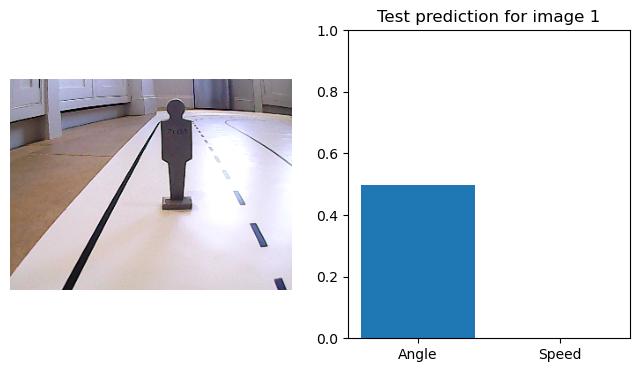

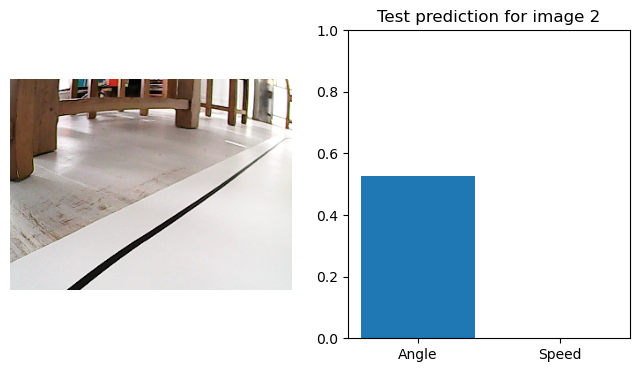

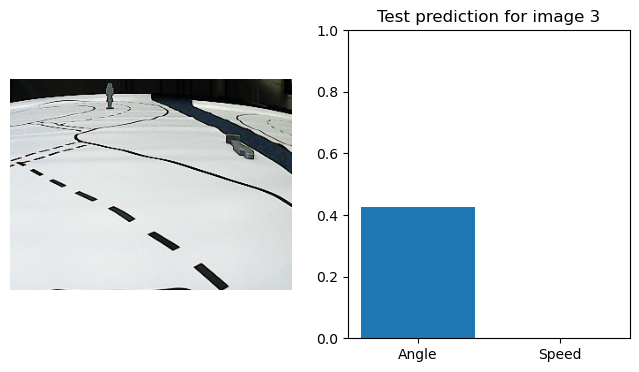

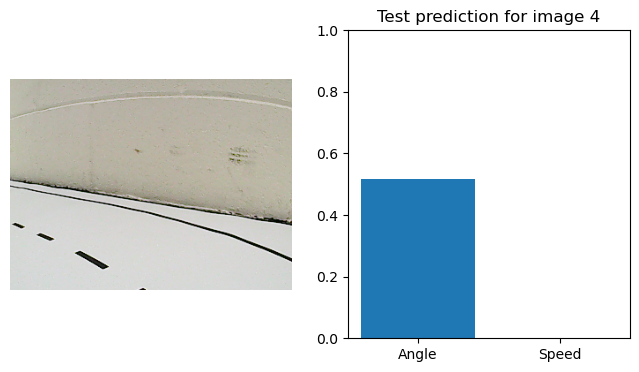

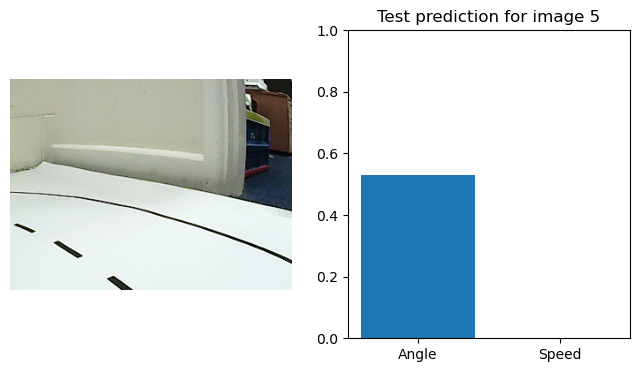

In [5]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras

# Load the saved model
loaded_model = keras.models.load_model('15_epoch_nn_model.h5')

# Print model architecture and hyperparameters
print("Model architecture and hyperparameters:")
print(loaded_model.summary())

# Load test predictions
test_predictions = np.load('test_predictions.npy')

# Load test images
test_images = []
for i in range(1, 1021):
    image = cv2.imread(f'/Users/tim/Desktop/postgraduate/semester 2/machine learning 2/assessment_project/machine-learning-in-science-ii-2023/test_data/test_data/{i}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)
test_images = np.array(test_images)

# Display test predictions along with images
num_images_to_display = 5  # change this value to display more images
for i in range(num_images_to_display):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.bar(['Angle', 'Speed'], test_predictions[i])
    plt.ylim(0, 1)
    plt.title(f"Test prediction for image {i+1}")
    plt.show()
